# Visualize CoVid-19 Deaths in "Financial Times" manner

This is about how to reproduce the CoVid-19 deaths figure in Financial Times.

![](https://www.ft.com/__origami/service/image/v2/images/raw/http%3A%2F%2Fcom.ft.imagepublish.upp-prod-us.s3.amazonaws.com%2F82051618-80dd-11ea-82f6-150830b3b99a?fit=scale-down&quality=highest&source=next&width=800)

- Data source:https://github.com/CSSEGISandData/COVID-19
- Necessary Python modules: `pandas`, `matplotlib`

In [96]:
# Import modules
import pandas as pd
from matplotlib import pyplot as plt, dates as mdates

We first read CSV files to dataframes by using `read_csv`. The raw csv files is available from the following URL:
- https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
- https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
- https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

In [77]:
#
# Read CSV files
#
prefix="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_"
suffix="_global.csv"
# 累積感染者数，累積死亡者，累積回復者のデータをデータフレームに読み込む
confirmed_df = pd.read_csv(prefix+"confirmed"+suffix)
deaths_df = pd.read_csv(prefix+"deaths"+suffix)
recovered_df = pd.read_csv(prefix+"recovered"+suffix)

As you can seee in [confirmed](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv), [deaths](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv) and [recovered](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), only "Province/State"-wise data is available for several countries, such as China, Australia and Canada. For these countries, we use the sum of the province/state-wise number as the total number.

In [78]:
# 
# Reformat the dataframe
# 
def reformat(df):
    # Find countries for which only province/state-wise data is available
    country_set = set(df["Country/Region"].values)
    country_set_with_total = set([df["Country/Region"][r] for r in range(len(df)) if pd.isnull(df["Province/State"][r])])
    country_set_without_total = country_set - country_set_with_total
    # For the countries only with province/state-wise data, we use the sum of these as the total record.
    df = df.set_index("Country/Region")
    series = dict()
    for country in country_set_without_total:
        series[country] = pd.Series(df.loc[country].iloc[:,3:].sum(), index = df.columns[3:], name=country)
    # Remove province/state-wise data
    df = df.reset_index()
    drop_rows = [l for l in range(len(df)) if not pd.isnull(df.loc[l,'Province/State'])]
    df = df.drop(drop_rows)
    df = df.set_index("Country/Region")
    # Remove Lat/Lon columns
    df = df.iloc[:,3:]
    # Restore the record of countries with province/state-wise data only.
    for s in series.values():
        df = df.append(s)
    # Replace column index by standard `datetime` type
    df.columns = pd.to_datetime(df.columns, format='%m/%d/%y')
    return df

# Reformat all dataframes by using `reformat` function
confirmed_df = reformat(confirmed_df)
deaths_df = reformat(deaths_df)
recovered_df = reformat(recovered_df)

Let `num_country` be the number of countries to be plotted. Pickup the first `num_country` with highest cumulative death and let them be `country_set`. You might explicitly set `country_set` as follows:
```
country_set = ['US', 'United Kingdom', 'Spain', 'France', 'Italy', 'Germany', 'Austria', 'Norway', 'Korea, South', 'Iran', 'India', 'Indonesia', 'Japan']
```

In [93]:
#
# Obtain the list of countries to be plotted
#
num_country = 10 # number of countries to be plotted.
# Find the first `num_country` countries with highest death.
dummy, country_set = zip(*sorted([(-deaths_df.loc[country][-1], country) for country in deaths_df.index])[:num_country])
# country_set を list 形式に直す
country_set = list(country_set)
# (Optional) Append Japan if not included.
if 'Japan' not in country_set:
    country_set += ['Japan']

The following function plots a rolling average of daily volume of dataframe `df`.

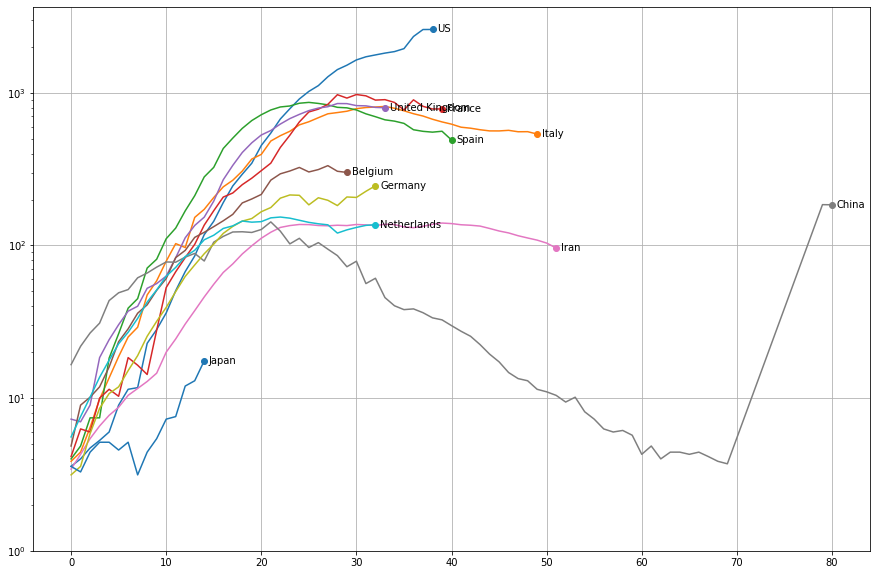

In [94]:
#
# Plot a 7-day rolling average of daily death since the first day of average daily death exceeds 3.
##
# Plot a 7-day rolling average of daily death since the first day of average daily death exceeds 3.
#
def plot_daily_rolling_by_days(df, country_set, window=7):
    fig, ax = plt.subplots(figsize=(15,10))
    for country in country_set:
        daily = df.loc[country].diff() # Obtain the daily volume from cumulative. 
        #daily_index = daily[daily>3].index # x-axis is the days since first day
        #daily_rolling = daily.rolling(7).mean()[daily_index]
        daily_rolling = daily.rolling(7).mean() # Obtain 7-day (default) rolling average
        # Days since first day of average daily death exceeds 3
        daily_index = daily_rolling[daily_rolling>3].index 
        daily_rolling = daily_rolling[daily_index]
        days = (daily_index-daily_index[0]).days
        # Plot the curve
        curve = ax.plot(days, daily_rolling, label=country)
        # Add a circle at the latest point
        x, y = days[-1], daily_rolling[-1] 
        ax.plot(x, y, 'o', color=curve[0].get_color())
        ax.text(x+0.5, y, country, verticalalignment='center')
    # Adjust figure
    plt.yscale('log')
    plt.grid()
    plt.ylim([1,plt.ylim()[1]])
    plt.show()
    return fig, ax
fig, ax = plot_daily_rolling_by_days(deaths_df, country_set)

You might interested in the original cumulative number of death with respect to the calendar dates.

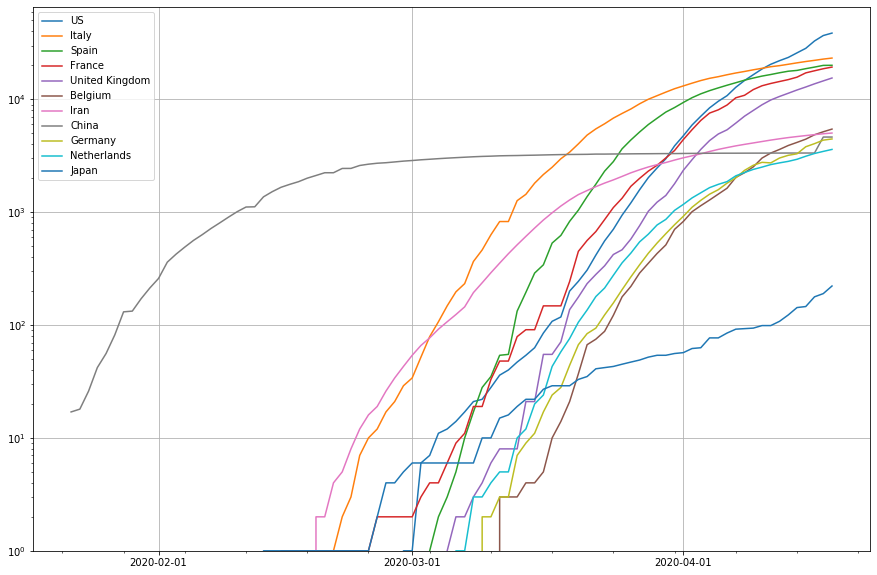

In [95]:
#
# Plot cumulative death with respect to the calendar dates.
#
def plot_cum(df, country_set):
    fig, ax = plt.subplots(figsize=(15,10))

    for country in country_set:
        curve = ax.plot(df.loc[country], label=country)
        # Add country name
        #x, y = df.columns[-1], df.loc[country][-1] 
        #ax.text(x, y, country, verticalalignment='center')

    # Ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator()) # set major ticks to be the beginning of month.
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator()) # set minor ticks to be week.
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    # Adjust figure
    plt.yscale('log')
    plt.grid()
    plt.legend()
    plt.ylim([1,plt.ylim()[1]])
    plt.show()
    return fig, ax
fig, ax = plot_cum(deaths_df, country_set)